In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import LabelEncoder
from IPython.display import display

In [2]:
def details(df):
    display(df.head())
    display(df.describe())
    display(df.info())

In [3]:
full_data = pd.read_csv("../input/sentiment-analysis-for-financial-news/all-data.csv", \
                        names=["sentiment", "news"])
details(full_data)

,sentiment,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


,sentiment,news
count,4846,4846
unique,3,4838
top,neutral,The issuer is solely responsible for the conte...
freq,2879,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   news       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


None

In [4]:
full_data.drop_duplicates(subset=["news"], keep="first", inplace=True)
details(full_data)

,sentiment,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


,sentiment,news
count,4838,4838
unique,3,4838
top,neutral,"Barclays Plc ( LSE : BARC ) ( NYSE : BCS ) , C..."
freq,2872,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4838 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4838 non-null   object
 1   news       4838 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


None

<AxesSubplot:>

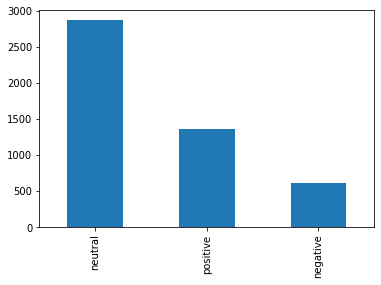

In [5]:
full_data["sentiment"].value_counts().plot(kind="bar")

In [6]:
seq_len = 512
num_samples = len(full_data)
print((num_samples,seq_len))

(4838, 512)


In [7]:
from transformers import BertTokenizer

In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokens = tokenizer(full_data["news"].tolist(),
                  max_length=seq_len,
                  padding="max_length",
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="np")

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [9]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [10]:
tokens.input_ids

array([[  101,  1792,  1106, ...,     0,     0,     0],
       [  101,  7882,  2728, ...,     0,     0,     0],
       [  101,  1109,  1835, ...,     0,     0,     0],
       ...,
       [  101, 20961,  5022, ...,     0,     0,     0],
       [  101, 20820,  3813, ...,     0,     0,     0],
       [  101, 15689,  1107, ...,     0,     0,     0]])

In [11]:
tokens.token_type_ids

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
tokens.attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [13]:
with open("news-ids.npy", "wb") as f:
    np.save(f, tokens.input_ids)
    
with open("news-mask.npy", "wb") as f:
    np.save(f, tokens.attention_mask)

In [14]:
le = LabelEncoder()
le.fit(full_data["sentiment"])
labels = list(int(x) for x in le.transform(le.classes_))
encodings = dict(zip(le.classes_, labels))
json.dump(encodings, open("./encodings.json", "w"))

In [15]:
y = full_data[["sentiment"]]

In [16]:
y["sentiment"] = le.transform(y["sentiment"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
y = pd.get_dummies(y[["sentiment"]].astype("category"))
with open("news-labels.npy", "wb") as f:
    np.save(f, y.values)